<a href="https://colab.research.google.com/github/adag21044/PoliticalTweetAnalyzer/blob/main/PoliticalTweetAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

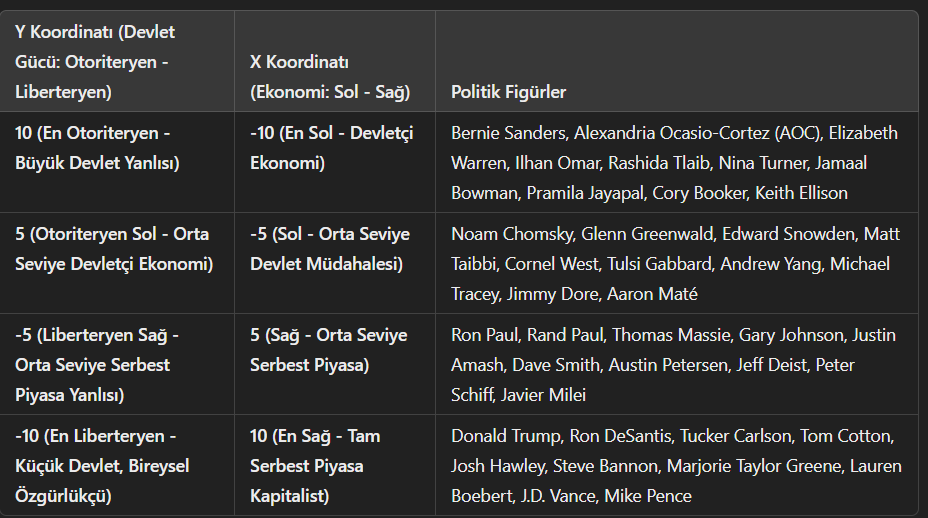

In [9]:
import re
import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [18]:
# 1️⃣ **ÖRNEK POLİTİK VERİ SETİ**
tweets_data = {
    "authoritarian_left": [
        "The government must regulate businesses for fairness.",
        "We need higher taxes on the rich for wealth redistribution.",
        "Public healthcare is a human right, not a privilege.",
        "Strong government policies will protect the working class."
    ],
    "libertarian_left": [
        "People should be free to make their own life choices.",
        "The government should not interfere in personal matters.",
        "Decentralization of power is key to real freedom.",
        "We need a social safety net, but with personal choice."
    ],
    "authoritarian_right": [
        "Strong borders make a strong nation!",
        "Law and order must be strictly enforced.",
        "Traditional values should be the foundation of our society.",
        "Military strength is necessary for national security."
    ],
    "libertarian_right": [
        "The free market is the best path to economic growth.",
        "Less government regulation means more innovation.",
        "People should have full control over their private property.",
        "Taxation is theft! Government should be as small as possible."
    ]
}

In [11]:
# 2️⃣ **METİN TEMİZLEME**
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)
    tweet = re.sub(r"@\w+|#", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)
    return tweet

for category in tweets_data:
    tweets_data[category] = [preprocess_tweet(tweet) for tweet in tweets_data[category]]

In [12]:
# ====================================
# ✅ 3️⃣ TRANSFORMER MODELİ YÜKLEME
# ====================================

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")
bert_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base")

def get_bert_embedding(tweet):
    tokens = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=50)
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).numpy().flatten()  # 🟣 Mean Pooling daha stabil

In [13]:
# ====================================
# ✅ 4️⃣ ELLE ETİKETLENMİŞ POLİTİK VERİLER
# ====================================

datasets = {
    "(-10,10)": pd.DataFrame({"text": [
        "Healthcare is a human right.",
        "We must tax billionaires fairly.",
        "Workers deserve a living wage.",
        "Climate change is the greatest threat to humanity."
    ]}),
    "(-5,5)": pd.DataFrame({"text": [
        "The Green New Deal is essential for our future.",
        "Public housing must be expanded and funded.",
        "Every American deserves dignified work and wages.",
        "We must challenge corporate power in Washington."
    ]}),
    "(5,-5)": pd.DataFrame({"text": [
        "The government should be as small as possible.",
        "End the Fed and return fiscal responsibility.",
        "Taxation should be minimal and transparent.",
        "Personal freedoms are the foundation of a healthy society.",
        "Thank you for your leadership @realDonaldTrump.",
        "President Trump's commitment to heightened border security is making America safer.",
        "President Trump IS the President of Peace.",
        "Where Joe Biden failed, President Trump will succeed."
    ]}),
    "(10,-10)": pd.DataFrame({"text": [
        "We will build the wall and secure our borders.",
        "Make America Great Again!",
        "America First, always.",
        "Our military is stronger than ever before."
    ]})
}

In [14]:
# ====================================
# ✅ 5️⃣ GERÇEK DATASETLER (CSV)
# ====================================

real_datasets = {
    "(-10,10)": pd.read_csv("/content/Bernie_tweets.csv", on_bad_lines="skip"),
    "(-5,5)": pd.read_csv("/content/aoc_tweets.csv", on_bad_lines="skip"),
    "(10,-10)": pd.read_csv("/content/trumptweets.csv", on_bad_lines="skip")
}


In [15]:
# ====================================
# ✅ 6️⃣ DEMOCRAT - REPUBLICAN DATASET
# ====================================

df_parties = pd.read_csv("/content/Democrat Vs. Republican Tweets.csv")
democrat_tweets = df_parties[df_parties["Party"] == "Democrat"]["Tweet"].tolist()
republican_tweets = df_parties[df_parties["Party"] == "Republican"]["Tweet"].tolist()

In [16]:
# ====================================
# ✅ 7️⃣ DATASET EMBEDDING + LABELING
# ====================================

point_map = {
    "(-10,10)": (-10, 10),
    "(-5,5)": (-5, 5),
    "(5,-5)": (5, -5),
    "(10,-10)": (10, -10)
}

X, y = [], []

# Democrat vs Republican Dataset
for tweet in tqdm(democrat_tweets, desc="Embedding Democrat (-5,5)"):
    X.append(get_bert_embedding(preprocess_tweet(tweet)))
    y.append((-5,5))

for tweet in tqdm(republican_tweets, desc="Embedding Republican (5,-5)"):
    X.append(get_bert_embedding(preprocess_tweet(tweet)))
    y.append((5,-5))

# Real Datasetler
for point, df in real_datasets.items():
    coords = point_map[point]
    tweets_column = next((col for col in df.columns if col in ["text", "Tweet", "body", "content"]), None)
    if tweets_column is None:
        raise ValueError("Beklenen sütun bulunamadı.")
    for tweet in tqdm(df[tweets_column].tolist(), desc=f"Embedding {point}"):
        X.append(get_bert_embedding(preprocess_tweet(tweet)))
        y.append(coords)


Embedding (10,-10): 100%|██████████| 41122/41122 [1:53:57<00:00,  6.01it/s]


In [20]:
# ====================================
# ✅ 8️⃣ MODEL EĞİTİMİ
# ====================================

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128),
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42,
    verbose=True
)
mlp.fit(X, y)
print("✅ Model retrained with full dataset!")

Iteration 1, loss = 9.75407561
Validation score: 0.551683
Iteration 2, loss = 7.97205615
Validation score: 0.578607
Iteration 3, loss = 7.16643759
Validation score: 0.580908
Iteration 4, loss = 6.52427767
Validation score: 0.585175
Iteration 5, loss = 5.89211720
Validation score: 0.585075
Iteration 6, loss = 5.38832180
Validation score: 0.582740
Iteration 7, loss = 4.88260797
Validation score: 0.578472
Iteration 8, loss = 4.40182168
Validation score: 0.568229
Iteration 9, loss = 3.99330823
Validation score: 0.558017
Iteration 10, loss = 3.64161315
Validation score: 0.518719
Iteration 11, loss = 3.48875951
Validation score: 0.551173
Iteration 12, loss = 2.97807032
Validation score: 0.540516
Iteration 13, loss = 2.80310023
Validation score: 0.534690
Iteration 14, loss = 2.58305701
Validation score: 0.529499
Iteration 15, loss = 2.34811543
Validation score: 0.521524
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
✅ Model retrained with full dat

In [21]:
# ====================================
# ✅ 9️⃣ TEST
# ====================================

my_tweet = "The government is getting too big and controlling everything."
cleaned_tweet = preprocess_tweet(my_tweet)
my_embedding = get_bert_embedding(cleaned_tweet).reshape(1, -1)
my_embedding = scaler.transform(my_embedding)
predicted_point = mlp.predict(my_embedding)[0]
print("Tahmin edilen pusula noktası:", predicted_point)


Tahmin edilen pusula noktası: [ 0.36613983 -0.37392962]


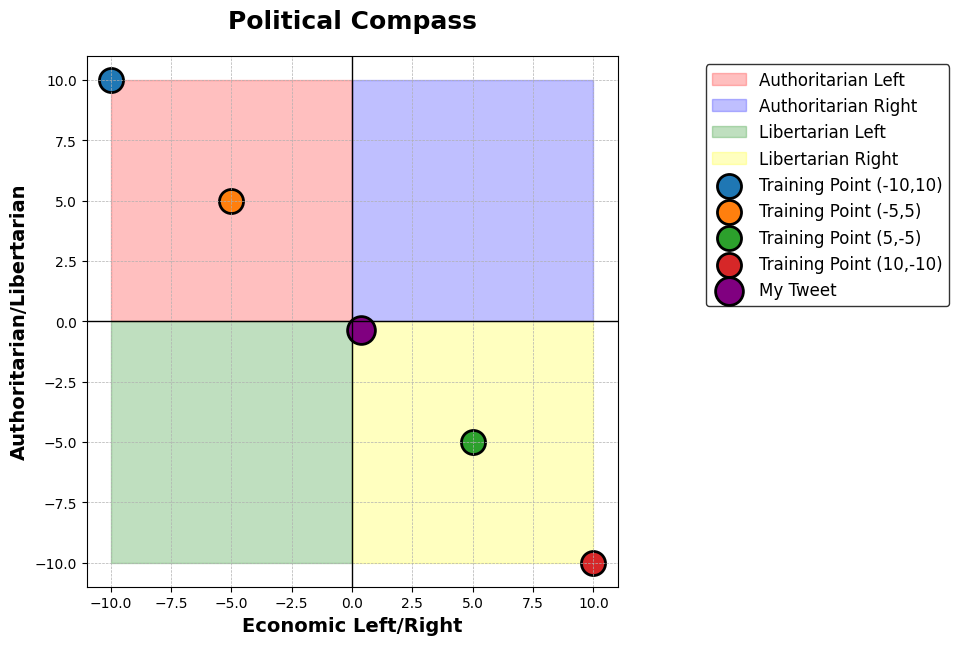

In [22]:
# ====================================
# ✅ 🔟 GÖRSELLEŞTİRME
# ====================================

plt.figure(figsize=(10, 10))
plt.axhline(0, color="black", linewidth=1)
plt.axvline(0, color="black", linewidth=1)

plt.fill_between([-10, 0], 0, 10, color="red", alpha=0.25, label="Authoritarian Left")
plt.fill_between([0, 10], 0, 10, color="blue", alpha=0.25, label="Authoritarian Right")
plt.fill_between([-10, 0], -10, 0, color="green", alpha=0.25, label="Libertarian Left")
plt.fill_between([0, 10], -10, 0, color="yellow", alpha=0.25, label="Libertarian Right")

plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Economic Left/Right", fontsize=14, fontweight="bold")
plt.ylabel("Authoritarian/Libertarian", fontsize=14, fontweight="bold")
plt.title("Political Compass", fontsize=18, fontweight="bold", pad=20)

for point, (x, y_) in point_map.items():
    plt.scatter(x, y_, s=300, label=f"Training Point {point}", edgecolors="black", linewidth=2)

plt.scatter(predicted_point[0], predicted_point[1], s=400, color="purple", label="My Tweet", edgecolors="black", linewidth=2)

plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12, frameon=True, edgecolor="black")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

**Save Datas**

In [23]:
import joblib

# ===========================
# ✅ Model ve Scaler Save
# ===========================

joblib.dump(mlp, "mlp_model.joblib")
joblib.dump(scaler, "scaler_model.joblib")

print("✅ Model ve Scaler kaydedildi!")


✅ Model ve Scaler kaydedildi!


**Load Datas**

In [ ]:
import joblib

# ===========================
# ✅ Model ve Scaler Load
# ===========================

mlp = joblib.load("mlp_model.joblib")
scaler = joblib.load("scaler_model.joblib")

print("✅ Model ve Scaler yüklendi!")
